In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla
from target import GMM_target, GMM_target2, Funnel, Gaussian_target
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

# import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target(args)

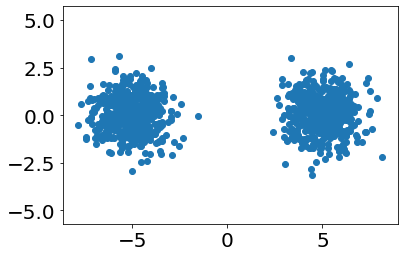

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
args.n_steps = 1000 # how many samples to use
args.n_warmup = 1000 # num of first samples to refuse

args.n_chains = 10 # how many chains to model

In [6]:
q_init = args.std_normal.sample((args.n_chains, args.z_dim))
p_init = args.std_normal.sample((args.n_chains, args.z_dim))

#### Vanilla HMC

In [7]:
vanilla_kernel = HMC_vanilla(args)

In [8]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

  2%|▏         | 22/1000 [00:00<00:04, 215.60it/s]

Now we are running warmup!


  2%|▏         | 24/1000 [00:00<00:04, 232.62it/s]

Now we are sampling!


100%|██████████| 1000/1000 [00:04<00:00, 225.67it/s]


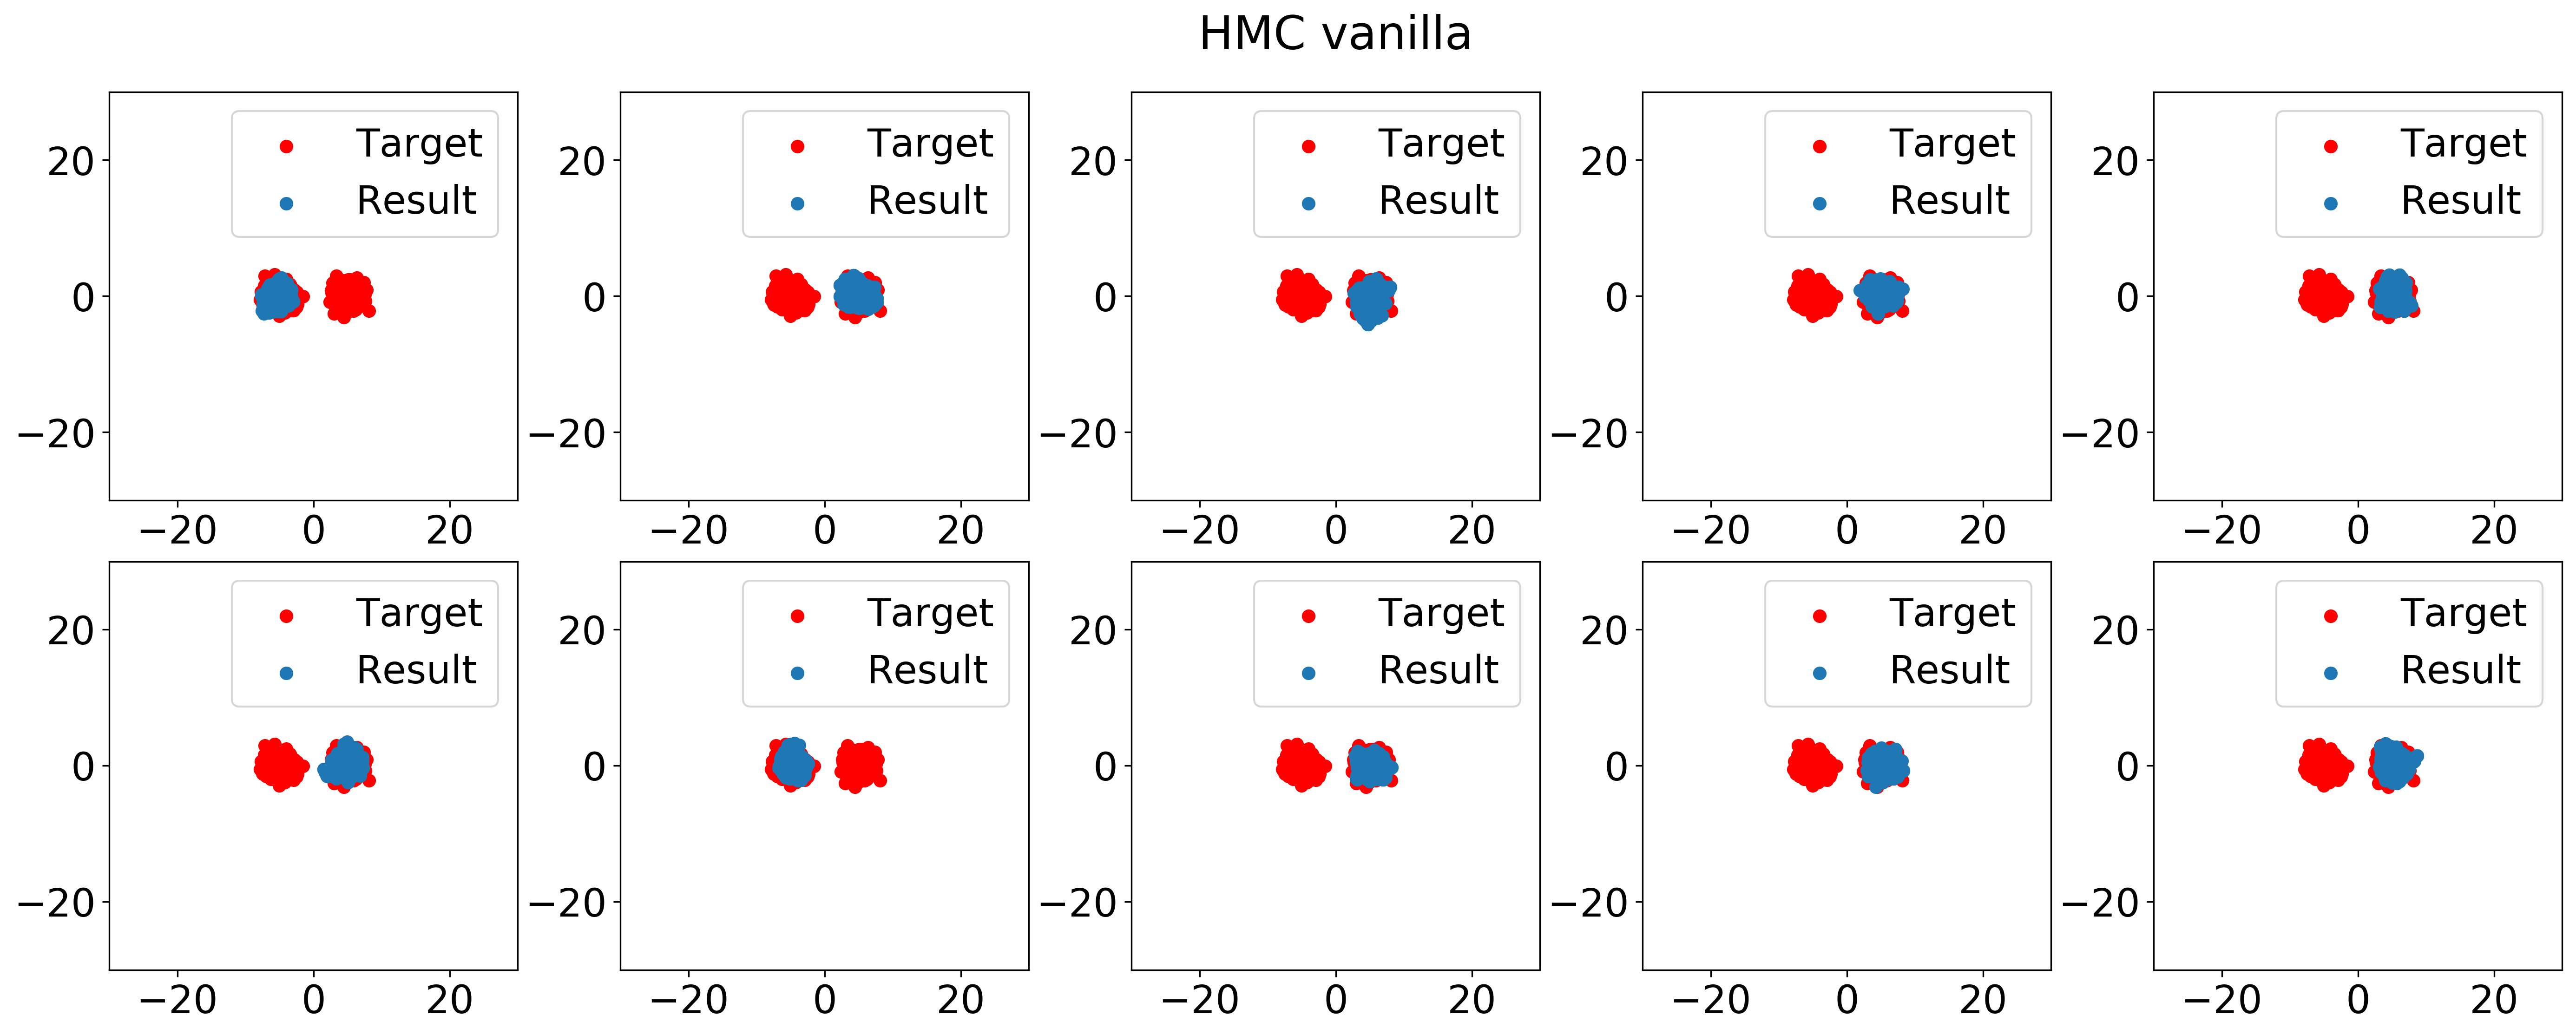

In [9]:
limit = 30
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

#### Ours HMC

In [10]:
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
our_kernel = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])

optimizer = torch.optim.Adam(params=transitions.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200)

##### Training

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 0 and on k = 1 we have for 0: 0.564 and for +1: 0.436
Step size for 0-th transition is 0.09999999403953552
Alpha (ref) for 0-th transition is 0.5
On batch number 0 and on k = 2 we have for 0: 0.484 and for +1: 0.516
Step size for 1-th transition is 0.09999999403953552
Alpha (ref) for 1-th transition is 0.5
On batch number 0 and on k = 3 we have for 0: 0.545 and for +1: 0.455
Step size for 2-th transition is 0.09999999403953552
Alpha (ref) for 2-th transition is 0.5
On batch number 0 and on k = 4 we have for 0: 0.581 and for +1: 0.419
Step size for 3-th transition is 0.09999999403953552
Alpha (ref) for 3-th transition is 0.5
On batch number 0 and on k = 5 we have for 0: 0.761 and for +1: 0.239
Step size for 4-th transition is 0.09999999403953552
Alpha (ref) for 4-th transition is 0.5


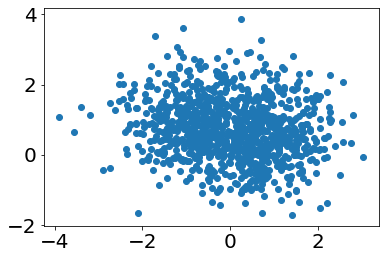

Current lr:  0.001
On batch number 0 ELBO is -18.81683349609375
On batch number 0 Best ELBO is -inf


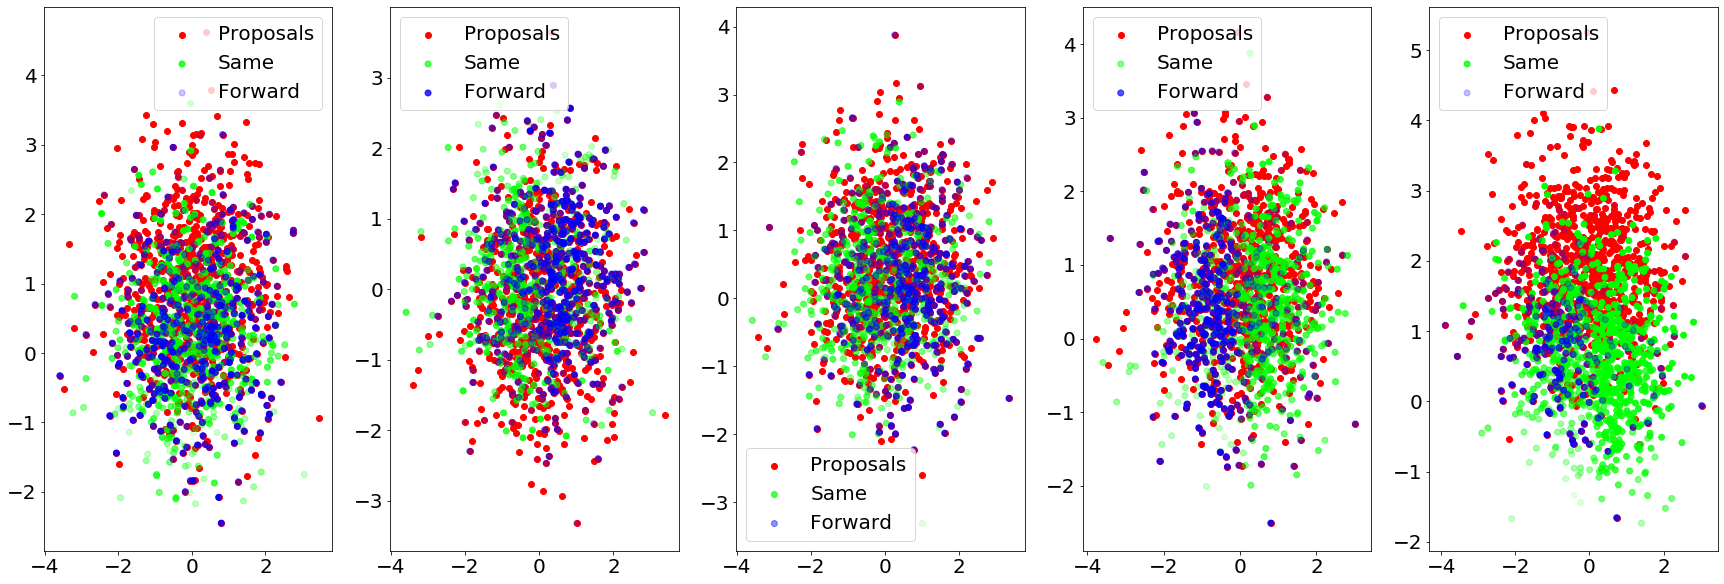

 10%|█         | 100/1000 [01:03<08:40,  1.73it/s]

On batch number 100 and on k = 1 we have for 0: 0.485 and for +1: 0.515
Step size for 0-th transition is 0.09653771668672562
Alpha (ref) for 0-th transition is 0.4753546416759491
On batch number 100 and on k = 2 we have for 0: 0.542 and for +1: 0.458
Step size for 1-th transition is 0.09749903529882431
Alpha (ref) for 1-th transition is 0.4751264750957489
On batch number 100 and on k = 3 we have for 0: 0.498 and for +1: 0.502
Step size for 2-th transition is 0.09783957153558731
Alpha (ref) for 2-th transition is 0.4754240810871124
On batch number 100 and on k = 4 we have for 0: 0.5 and for +1: 0.5
Step size for 3-th transition is 0.09907815605401993
Alpha (ref) for 3-th transition is 0.4750611484050751
On batch number 100 and on k = 5 we have for 0: 0.537 and for +1: 0.463
Step size for 4-th transition is 0.10069430619478226
Alpha (ref) for 4-th transition is 0.4747234284877777


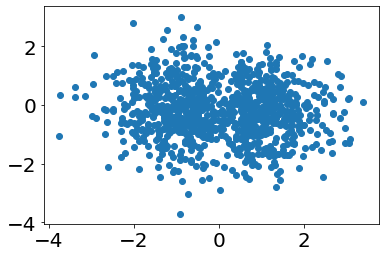

Current lr:  0.001
On batch number 100 ELBO is -15.601800918579102
On batch number 100 Best ELBO is -13.699965476989746


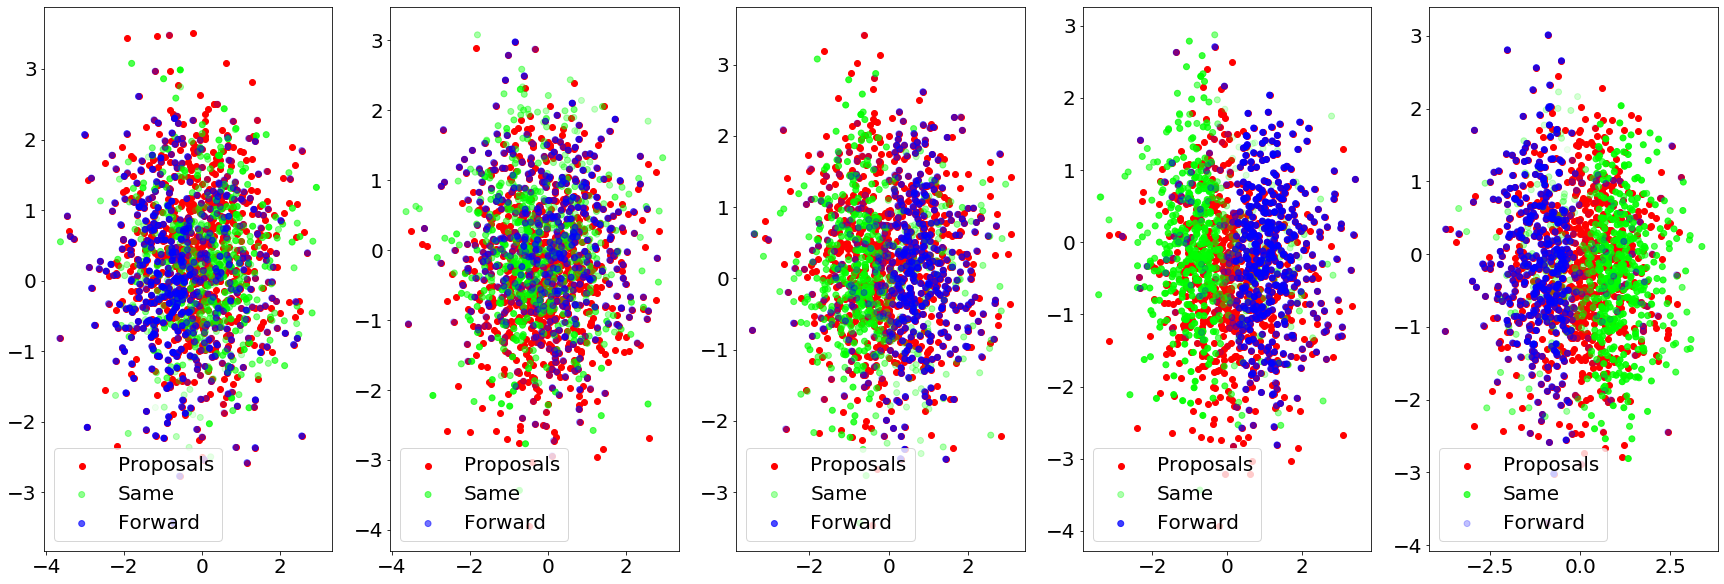

 20%|██        | 200/1000 [02:06<08:32,  1.56it/s]

On batch number 200 and on k = 1 we have for 0: 0.361 and for +1: 0.639
Step size for 0-th transition is 0.0942310318350792
Alpha (ref) for 0-th transition is 0.4498423635959625
On batch number 200 and on k = 2 we have for 0: 0.773 and for +1: 0.227
Step size for 1-th transition is 0.09629248827695847
Alpha (ref) for 1-th transition is 0.4494513273239136
On batch number 200 and on k = 3 we have for 0: 0.603 and for +1: 0.397
Step size for 2-th transition is 0.0944267138838768
Alpha (ref) for 2-th transition is 0.4500958323478699
On batch number 200 and on k = 4 we have for 0: 0.679 and for +1: 0.321
Step size for 3-th transition is 0.09697301685810089
Alpha (ref) for 3-th transition is 0.44959238171577454
On batch number 200 and on k = 5 we have for 0: 0.431 and for +1: 0.569
Step size for 4-th transition is 0.10134455561637878
Alpha (ref) for 4-th transition is 0.4491671621799469


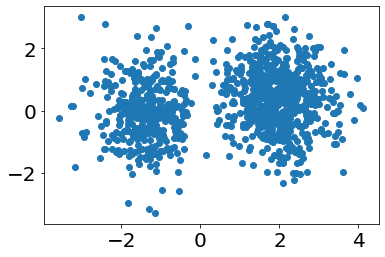

Current lr:  0.001
On batch number 200 ELBO is -16.39926528930664
On batch number 200 Best ELBO is -13.240013122558594


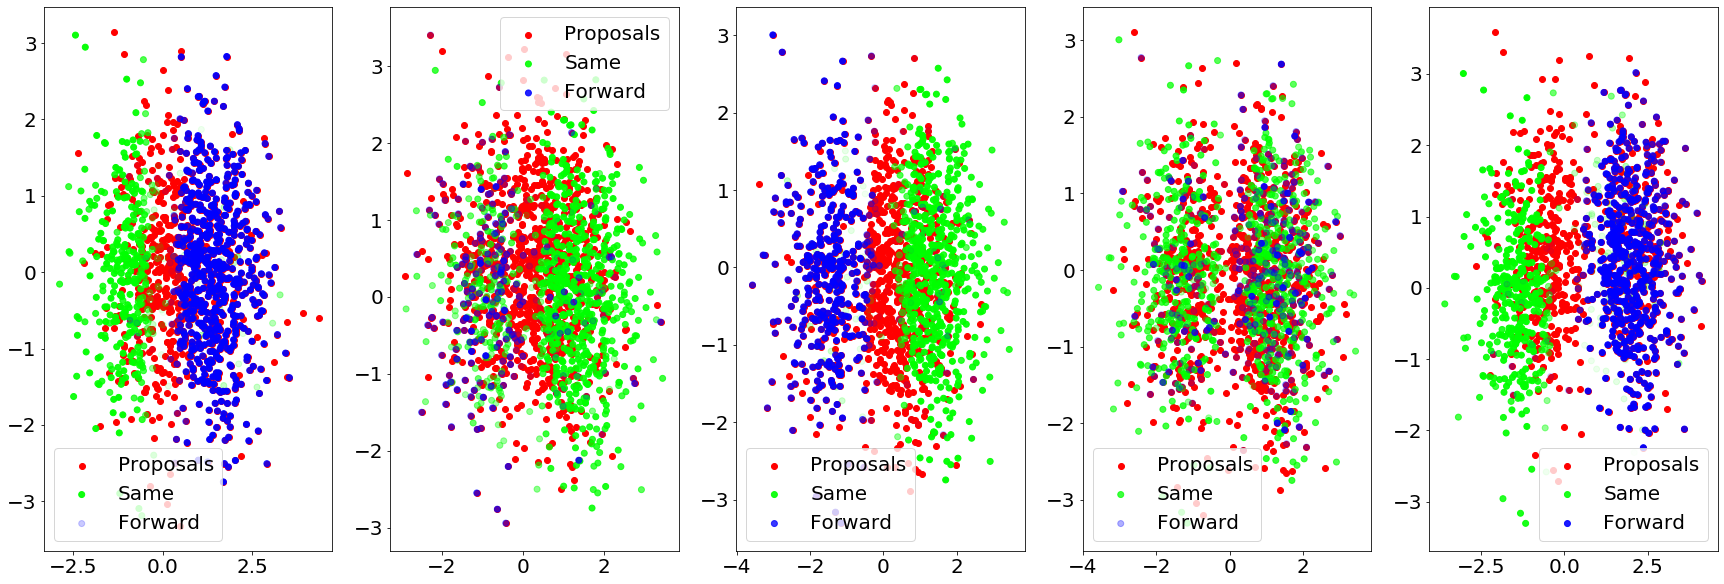

 30%|███       | 300/1000 [03:08<07:26,  1.57it/s]

On batch number 300 and on k = 1 we have for 0: 0.388 and for +1: 0.612
Step size for 0-th transition is 0.09313409775495529
Alpha (ref) for 0-th transition is 0.42454367876052856
On batch number 300 and on k = 2 we have for 0: 0.576 and for +1: 0.424
Step size for 1-th transition is 0.09468565881252289
Alpha (ref) for 1-th transition is 0.4237040579319
On batch number 300 and on k = 3 we have for 0: 0.466 and for +1: 0.534
Step size for 2-th transition is 0.09216240793466568
Alpha (ref) for 2-th transition is 0.4245050549507141
On batch number 300 and on k = 4 we have for 0: 0.514 and for +1: 0.486
Step size for 3-th transition is 0.09604621678590775
Alpha (ref) for 3-th transition is 0.423412024974823
On batch number 300 and on k = 5 we have for 0: 0.51 and for +1: 0.49
Step size for 4-th transition is 0.10143756866455078
Alpha (ref) for 4-th transition is 0.4236166179180145


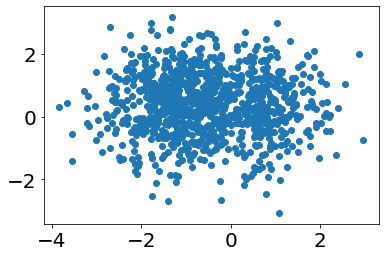

Current lr:  0.001
On batch number 300 ELBO is -16.476879119873047
On batch number 300 Best ELBO is -13.240013122558594


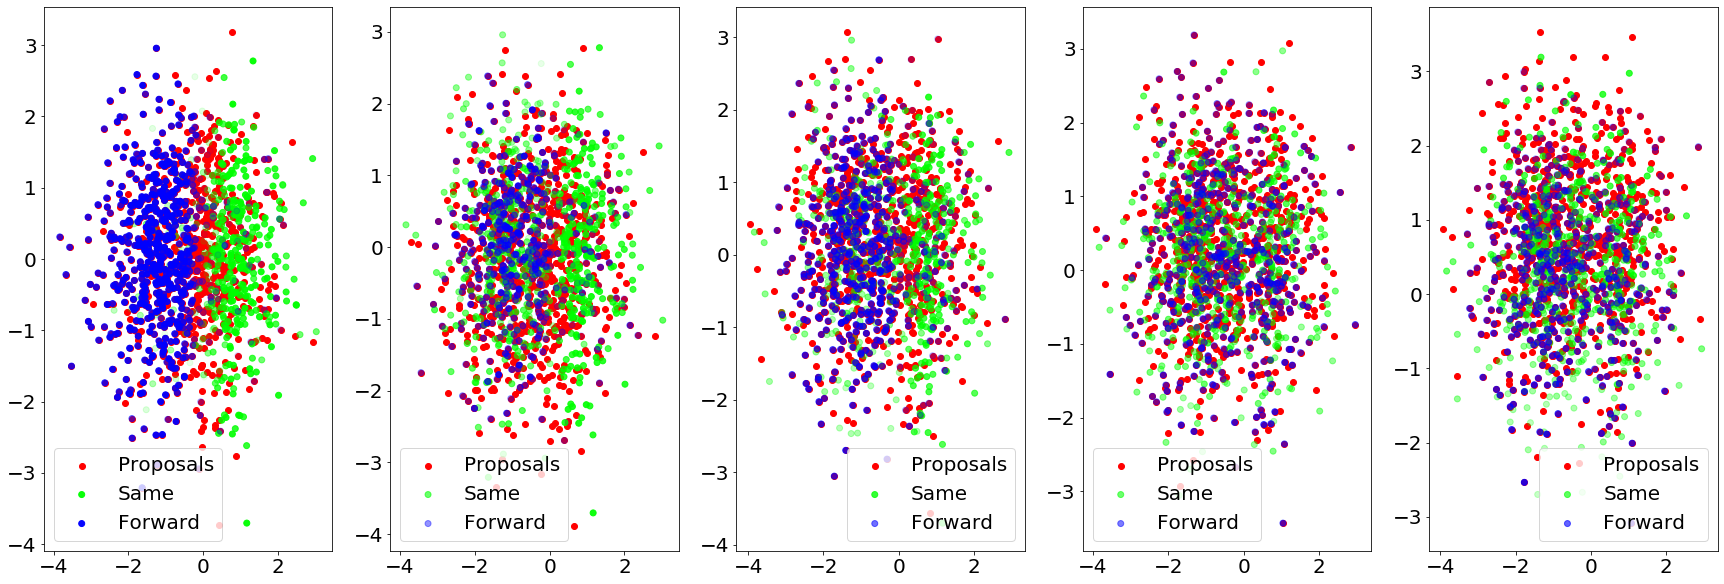

 40%|████      | 400/1000 [04:11<05:42,  1.75it/s]

On batch number 400 and on k = 1 we have for 0: 0.46 and for +1: 0.54
Step size for 0-th transition is 0.09295070916414261
Alpha (ref) for 0-th transition is 0.4201805591583252
On batch number 400 and on k = 2 we have for 0: 0.483 and for +1: 0.517
Step size for 1-th transition is 0.09434991329908371
Alpha (ref) for 1-th transition is 0.4192999005317688
On batch number 400 and on k = 3 we have for 0: 0.564 and for +1: 0.436
Step size for 2-th transition is 0.09204237908124924
Alpha (ref) for 2-th transition is 0.4200988709926605
On batch number 400 and on k = 4 we have for 0: 0.308 and for +1: 0.692
Step size for 3-th transition is 0.09574095159769058
Alpha (ref) for 3-th transition is 0.41900649666786194
On batch number 400 and on k = 5 we have for 0: 0.746 and for +1: 0.254
Step size for 4-th transition is 0.10116482526063919
Alpha (ref) for 4-th transition is 0.41924795508384705


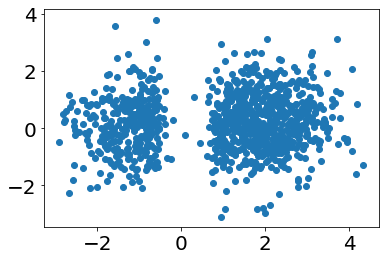

Current lr:  0.0001
On batch number 400 ELBO is -17.36342430114746
On batch number 400 Best ELBO is -13.240013122558594


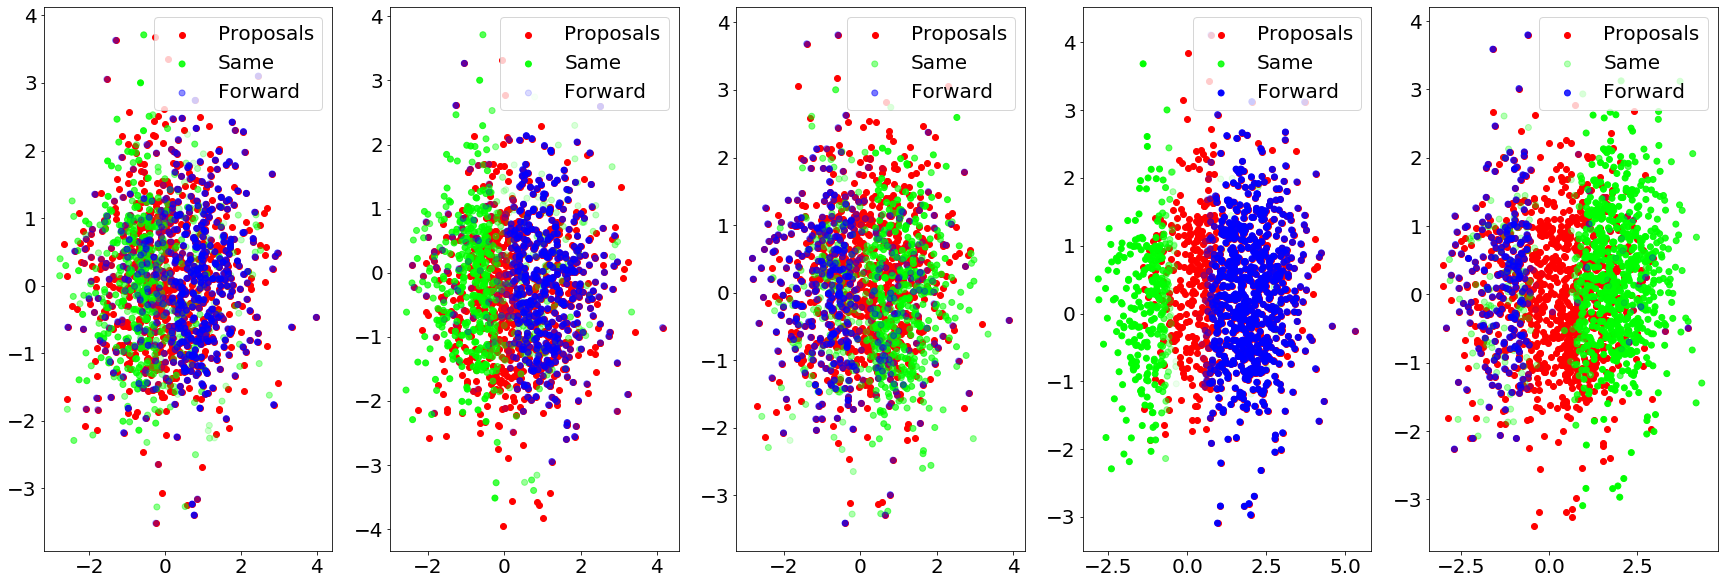

 50%|█████     | 500/1000 [05:15<05:21,  1.55it/s]

On batch number 500 and on k = 1 we have for 0: 0.464 and for +1: 0.536
Step size for 0-th transition is 0.09283711761236191
Alpha (ref) for 0-th transition is 0.4176803231239319
On batch number 500 and on k = 2 we have for 0: 0.566 and for +1: 0.434
Step size for 1-th transition is 0.09421279281377792
Alpha (ref) for 1-th transition is 0.416759729385376
On batch number 500 and on k = 3 we have for 0: 0.551 and for +1: 0.449
Step size for 2-th transition is 0.0919497087597847
Alpha (ref) for 2-th transition is 0.4175763726234436
On batch number 500 and on k = 4 we have for 0: 0.392 and for +1: 0.608
Step size for 3-th transition is 0.09544029831886292
Alpha (ref) for 3-th transition is 0.41647571325302124
On batch number 500 and on k = 5 we have for 0: 0.712 and for +1: 0.288
Step size for 4-th transition is 0.10102767497301102
Alpha (ref) for 4-th transition is 0.4166775047779083


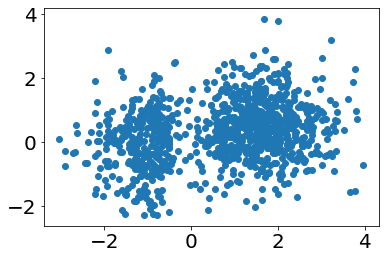

Current lr:  0.0001
On batch number 500 ELBO is -16.159290313720703
On batch number 500 Best ELBO is -13.240013122558594


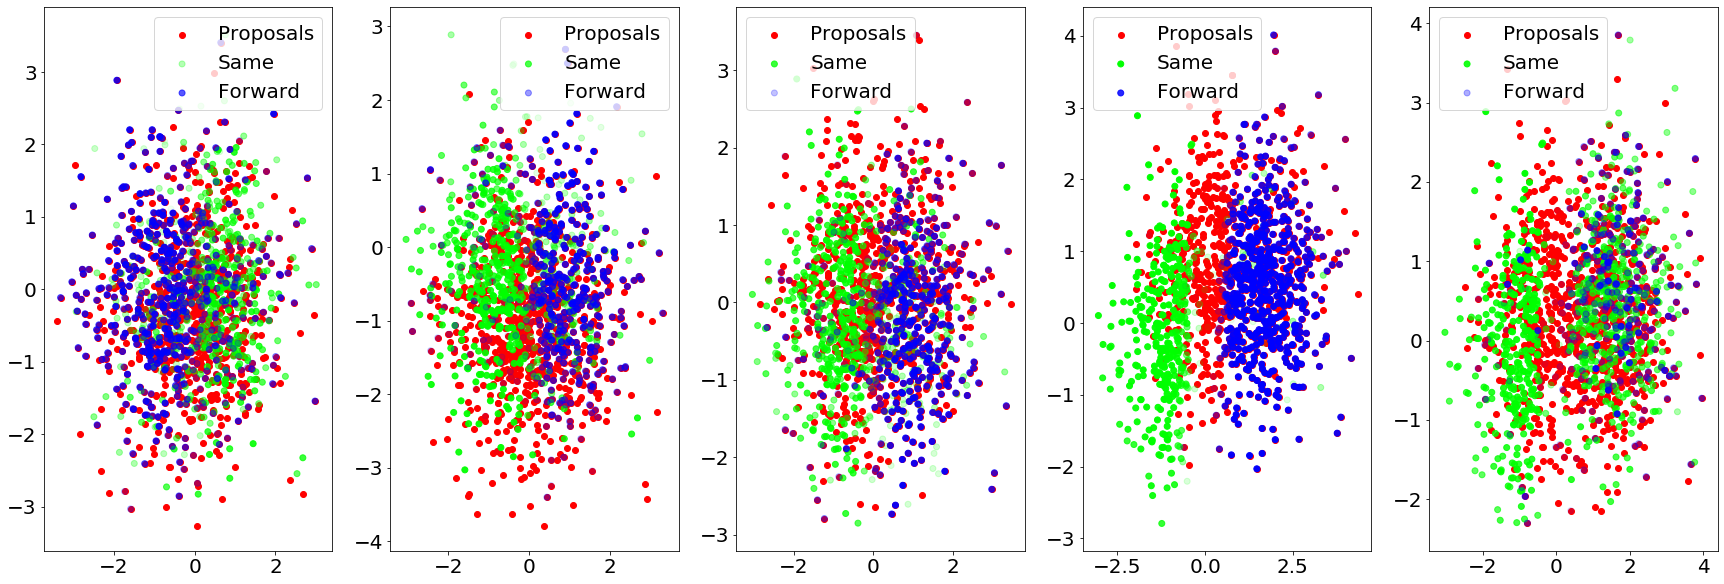

 60%|██████    | 600/1000 [06:18<03:59,  1.67it/s]

On batch number 600 and on k = 1 we have for 0: 0.438 and for +1: 0.562
Step size for 0-th transition is 0.09281965345144272
Alpha (ref) for 0-th transition is 0.4172321557998657
On batch number 600 and on k = 2 we have for 0: 0.512 and for +1: 0.488
Step size for 1-th transition is 0.09420115500688553
Alpha (ref) for 1-th transition is 0.4163128733634949
On batch number 600 and on k = 3 we have for 0: 0.489 and for +1: 0.511
Step size for 2-th transition is 0.09192664921283722
Alpha (ref) for 2-th transition is 0.41711607575416565
On batch number 600 and on k = 4 we have for 0: 0.482 and for +1: 0.518
Step size for 3-th transition is 0.09538081288337708
Alpha (ref) for 3-th transition is 0.41601961851119995
On batch number 600 and on k = 5 we have for 0: 0.408 and for +1: 0.592
Step size for 4-th transition is 0.10103998333215714
Alpha (ref) for 4-th transition is 0.4162209928035736


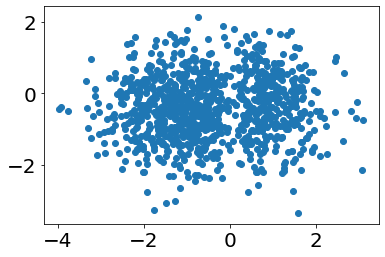

Current lr:  1e-05
On batch number 600 ELBO is -16.902759552001953
On batch number 600 Best ELBO is -13.240013122558594


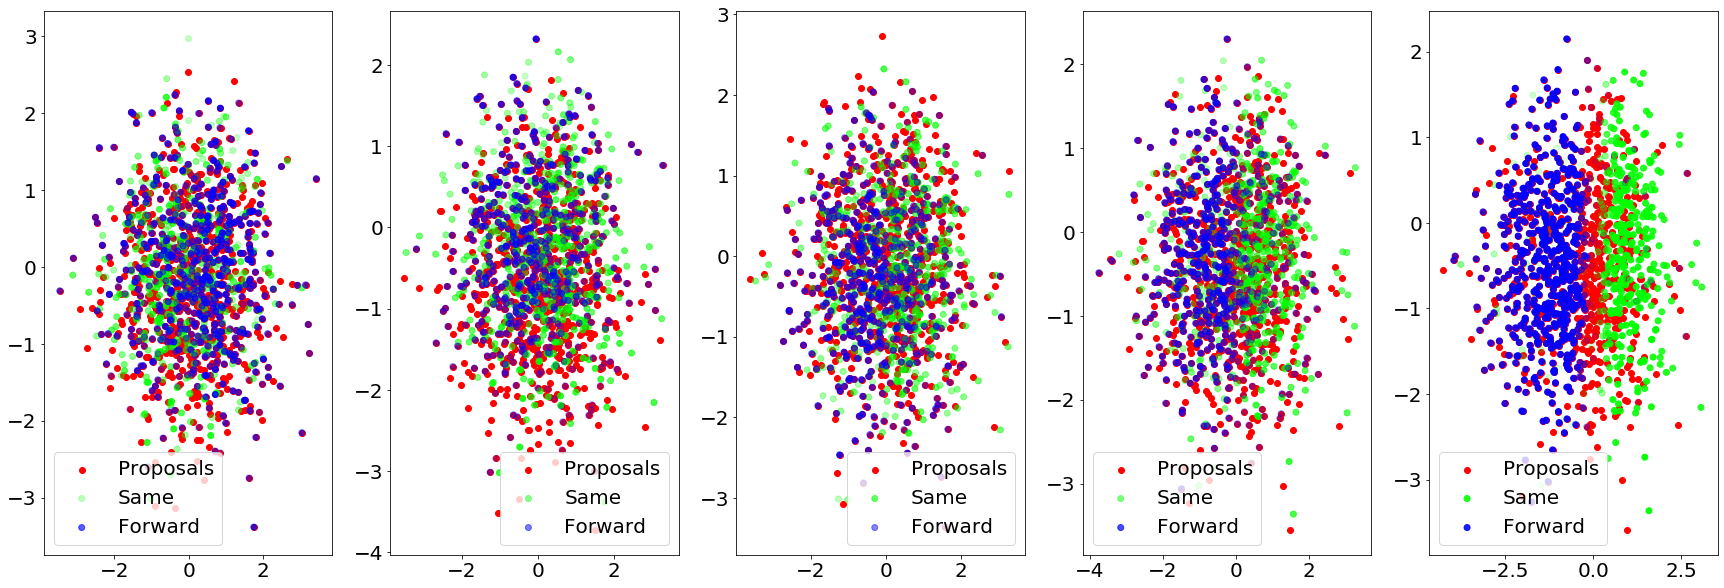

 70%|███████   | 700/1000 [07:21<03:10,  1.57it/s]

On batch number 700 and on k = 1 we have for 0: 0.532 and for +1: 0.468
Step size for 0-th transition is 0.0928148478269577
Alpha (ref) for 0-th transition is 0.41698288917541504
On batch number 700 and on k = 2 we have for 0: 0.491 and for +1: 0.509
Step size for 1-th transition is 0.09418146312236786
Alpha (ref) for 1-th transition is 0.4160653352737427
On batch number 700 and on k = 3 we have for 0: 0.57 and for +1: 0.43
Step size for 2-th transition is 0.09190701693296432
Alpha (ref) for 2-th transition is 0.4168680012226105
On batch number 700 and on k = 4 we have for 0: 0.604 and for +1: 0.396
Step size for 3-th transition is 0.09536769241094589
Alpha (ref) for 3-th transition is 0.4157709777355194
On batch number 700 and on k = 5 we have for 0: 0.521 and for +1: 0.479
Step size for 4-th transition is 0.10102979838848114
Alpha (ref) for 4-th transition is 0.41597121953964233


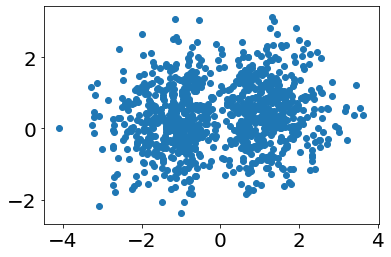

Current lr:  1e-05
On batch number 700 ELBO is -16.534618377685547
On batch number 700 Best ELBO is -13.240013122558594


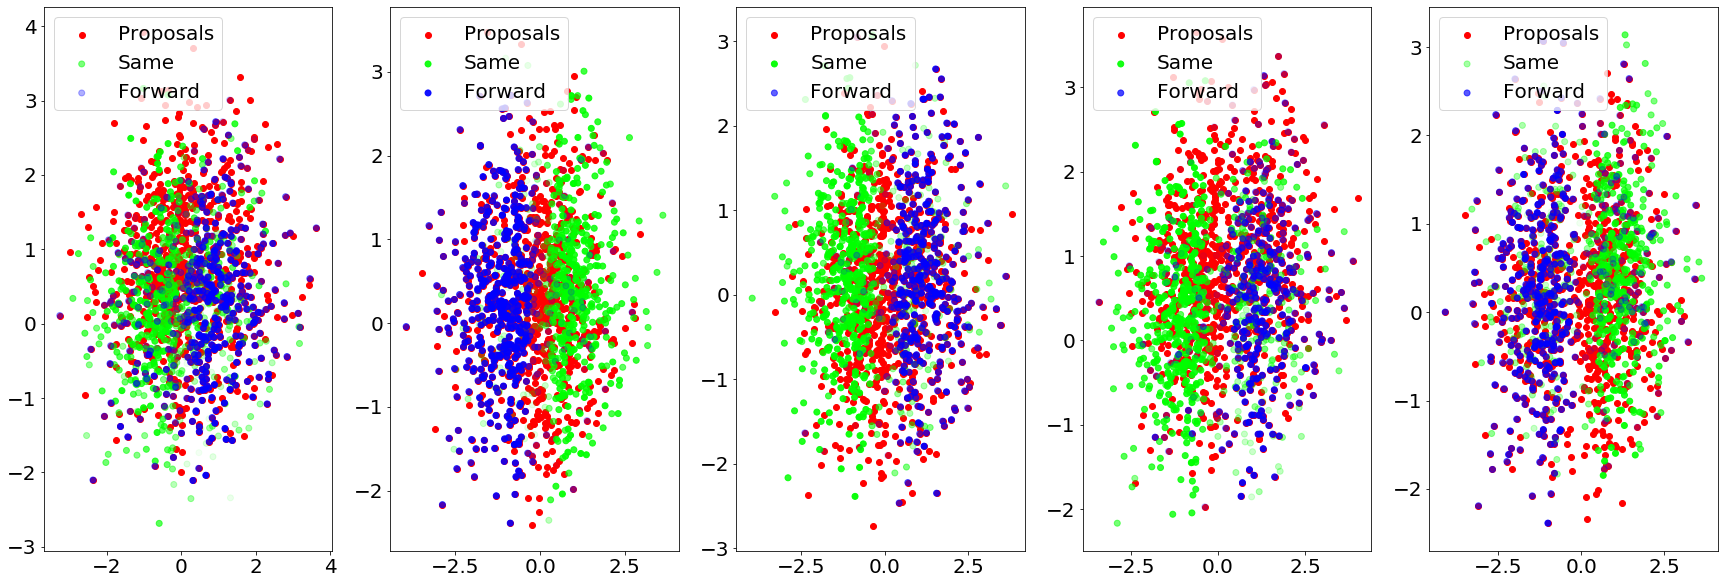

 80%|████████  | 800/1000 [08:20<01:58,  1.69it/s]

On batch number 800 and on k = 1 we have for 0: 0.301 and for +1: 0.699
Step size for 0-th transition is 0.0928133875131607
Alpha (ref) for 0-th transition is 0.4169362187385559
On batch number 800 and on k = 2 we have for 0: 0.803 and for +1: 0.197
Step size for 1-th transition is 0.09417721629142761
Alpha (ref) for 1-th transition is 0.41601812839508057
On batch number 800 and on k = 3 we have for 0: 0.697 and for +1: 0.303
Step size for 2-th transition is 0.09190631657838821
Alpha (ref) for 2-th transition is 0.4168210029602051
On batch number 800 and on k = 4 we have for 0: 0.662 and for +1: 0.338
Step size for 3-th transition is 0.09536569565534592
Alpha (ref) for 3-th transition is 0.415723592042923
On batch number 800 and on k = 5 we have for 0: 0.686 and for +1: 0.314
Step size for 4-th transition is 0.10102497786283493
Alpha (ref) for 4-th transition is 0.4159243106842041


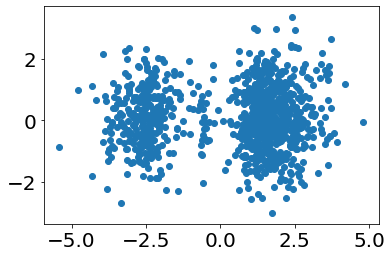

Current lr:  1.0000000000000002e-06
On batch number 800 ELBO is -17.656339645385742
On batch number 800 Best ELBO is -13.240013122558594


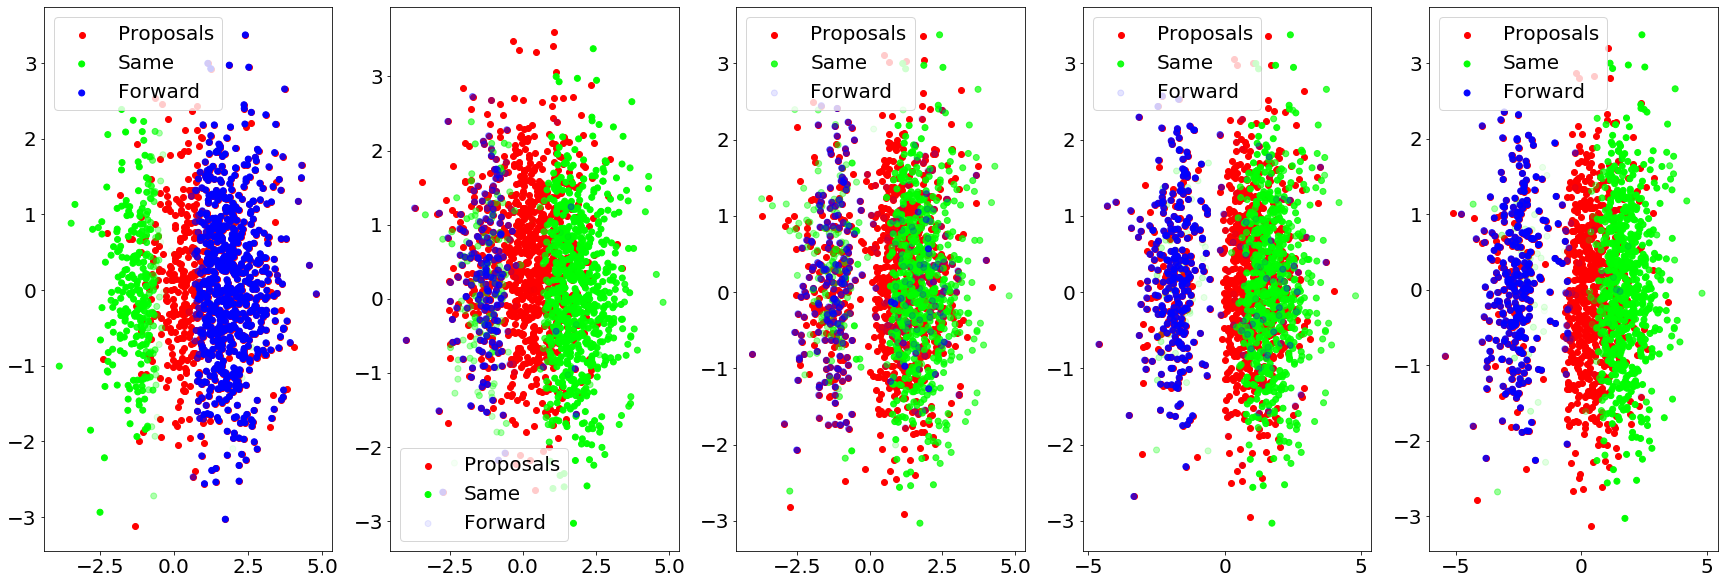

 90%|█████████ | 900/1000 [09:24<01:04,  1.56it/s]

On batch number 900 and on k = 1 we have for 0: 0.408 and for +1: 0.592
Step size for 0-th transition is 0.09280931949615479
Alpha (ref) for 0-th transition is 0.41691163182258606
On batch number 900 and on k = 2 we have for 0: 0.646 and for +1: 0.354
Step size for 1-th transition is 0.09417656809091568
Alpha (ref) for 1-th transition is 0.4159935414791107
On batch number 900 and on k = 3 we have for 0: 0.613 and for +1: 0.387
Step size for 2-th transition is 0.09190495312213898
Alpha (ref) for 2-th transition is 0.41679662466049194
On batch number 900 and on k = 4 we have for 0: 0.517 and for +1: 0.483
Step size for 3-th transition is 0.09536416828632355
Alpha (ref) for 3-th transition is 0.41569915413856506
On batch number 900 and on k = 5 we have for 0: 0.62 and for +1: 0.38
Step size for 4-th transition is 0.10102690756320953
Alpha (ref) for 4-th transition is 0.41589975357055664


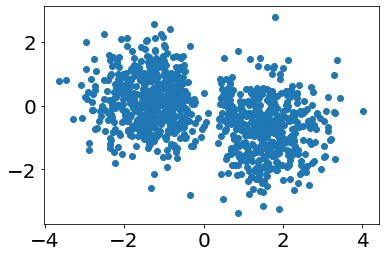

Current lr:  1.0000000000000002e-06
On batch number 900 ELBO is -17.825834274291992
On batch number 900 Best ELBO is -13.240013122558594


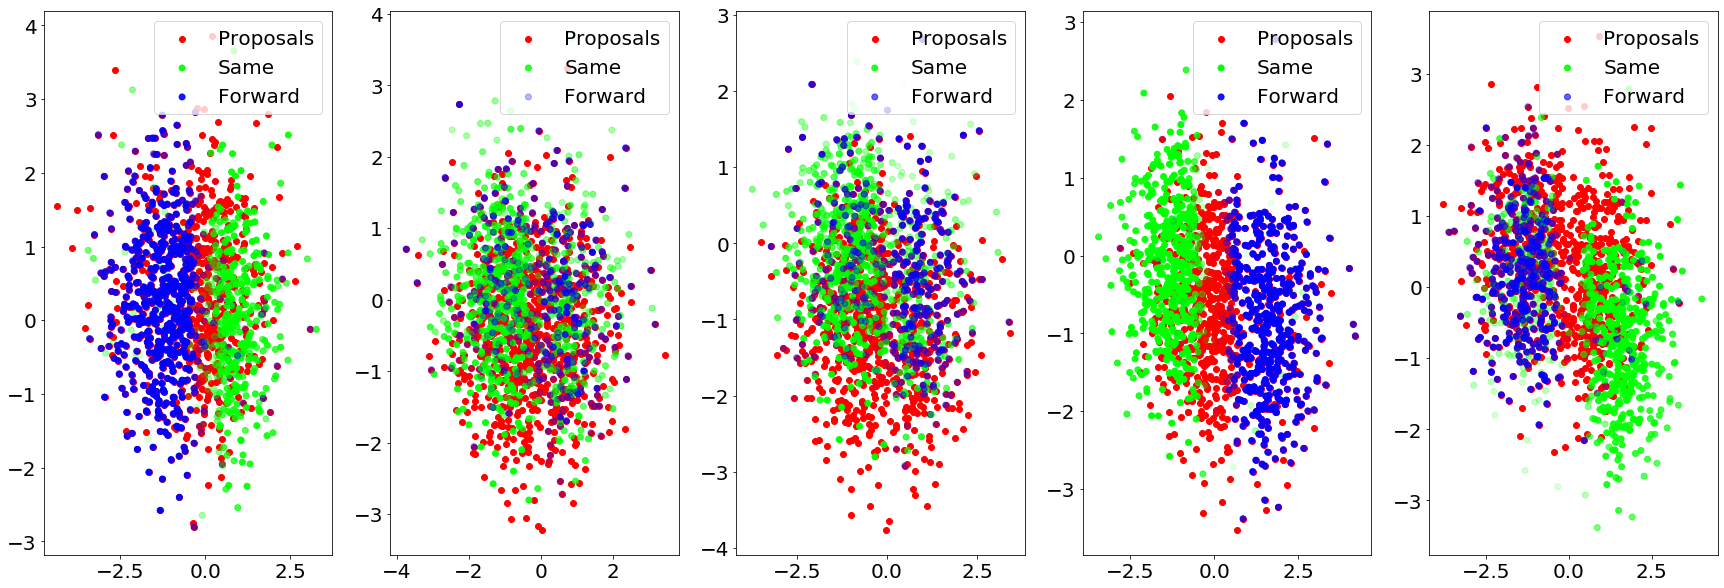

100%|██████████| 1000/1000 [10:27<00:00,  1.59it/s]


In [11]:
print_info_ = 100
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac):
#     pdb.set_trace()
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_r = -args.K * torch_log_2
    ## Loss version 1
#     log_m = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha
#     elbo_full = log_p + log_r - log_m
#     grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    ## Loss version 2
    log_m_tilde = args.std_normal.log_prob(q_old).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac
    log_m = log_m_tilde + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(log_m_tilde + sum_log_alpha * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), grad_elbo

if args.step_conditioning == 'fixed':
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]

iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    q_old = args.std_normal.sample((args.train_batch_size, args.z_dim)).requires_grad_(True)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
    # run training cycle
    for k in range(args.K):
        q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        if (batch_num) % print_info_ == 0:
            print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
                                                        (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
            print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
            print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
        fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
        label = ['Same', 'Forward']
        for kk in range(args.K):
            ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
            for d in [0., 1.]:
                z_c = array_z[kk][array_directions[kk]==d]
                alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
                color = np.zeros((z_c.shape[0], 4))
                color[:, 3] = alpha_c
                color[:, int(d + 1)] = 1.
                ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
#                 ax[kk].set_xlim((-x_lim, x_lim))
#                 ax[kk].set_ylim((-y_lim, y_lim))
                ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [12]:
# our_kernel = transitions
for p in our_kernel.parameters():
    p.requires_grad_(False)

In [13]:
q_new = q_init
p_new = p_init

print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        q_new, p_new, _, _, _, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                   k=cond_vectors[k])
iterator.close()
    
samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
print("Now we are sampling!")

iterator = tqdm(range(args.n_steps // args.K))
for i in iterator:
    q_new = q_new.detach().requires_grad_(True)
    p_new = p_new.detach().requires_grad_(True)
    for k in range(args.K):
        if args.step_conditioning == 'free':
            cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        q_new, p_new, _, _, a, _ = our_kernel[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
                                                                       k=cond_vectors[k])
        samples_our[i] = q_new.detach()
iterator.close()

  0%|          | 1/200 [00:00<00:33,  6.01it/s]

Now we are running warmup!


  0%|          | 1/200 [00:00<00:25,  7.70it/s]

Now we are sampling!


100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


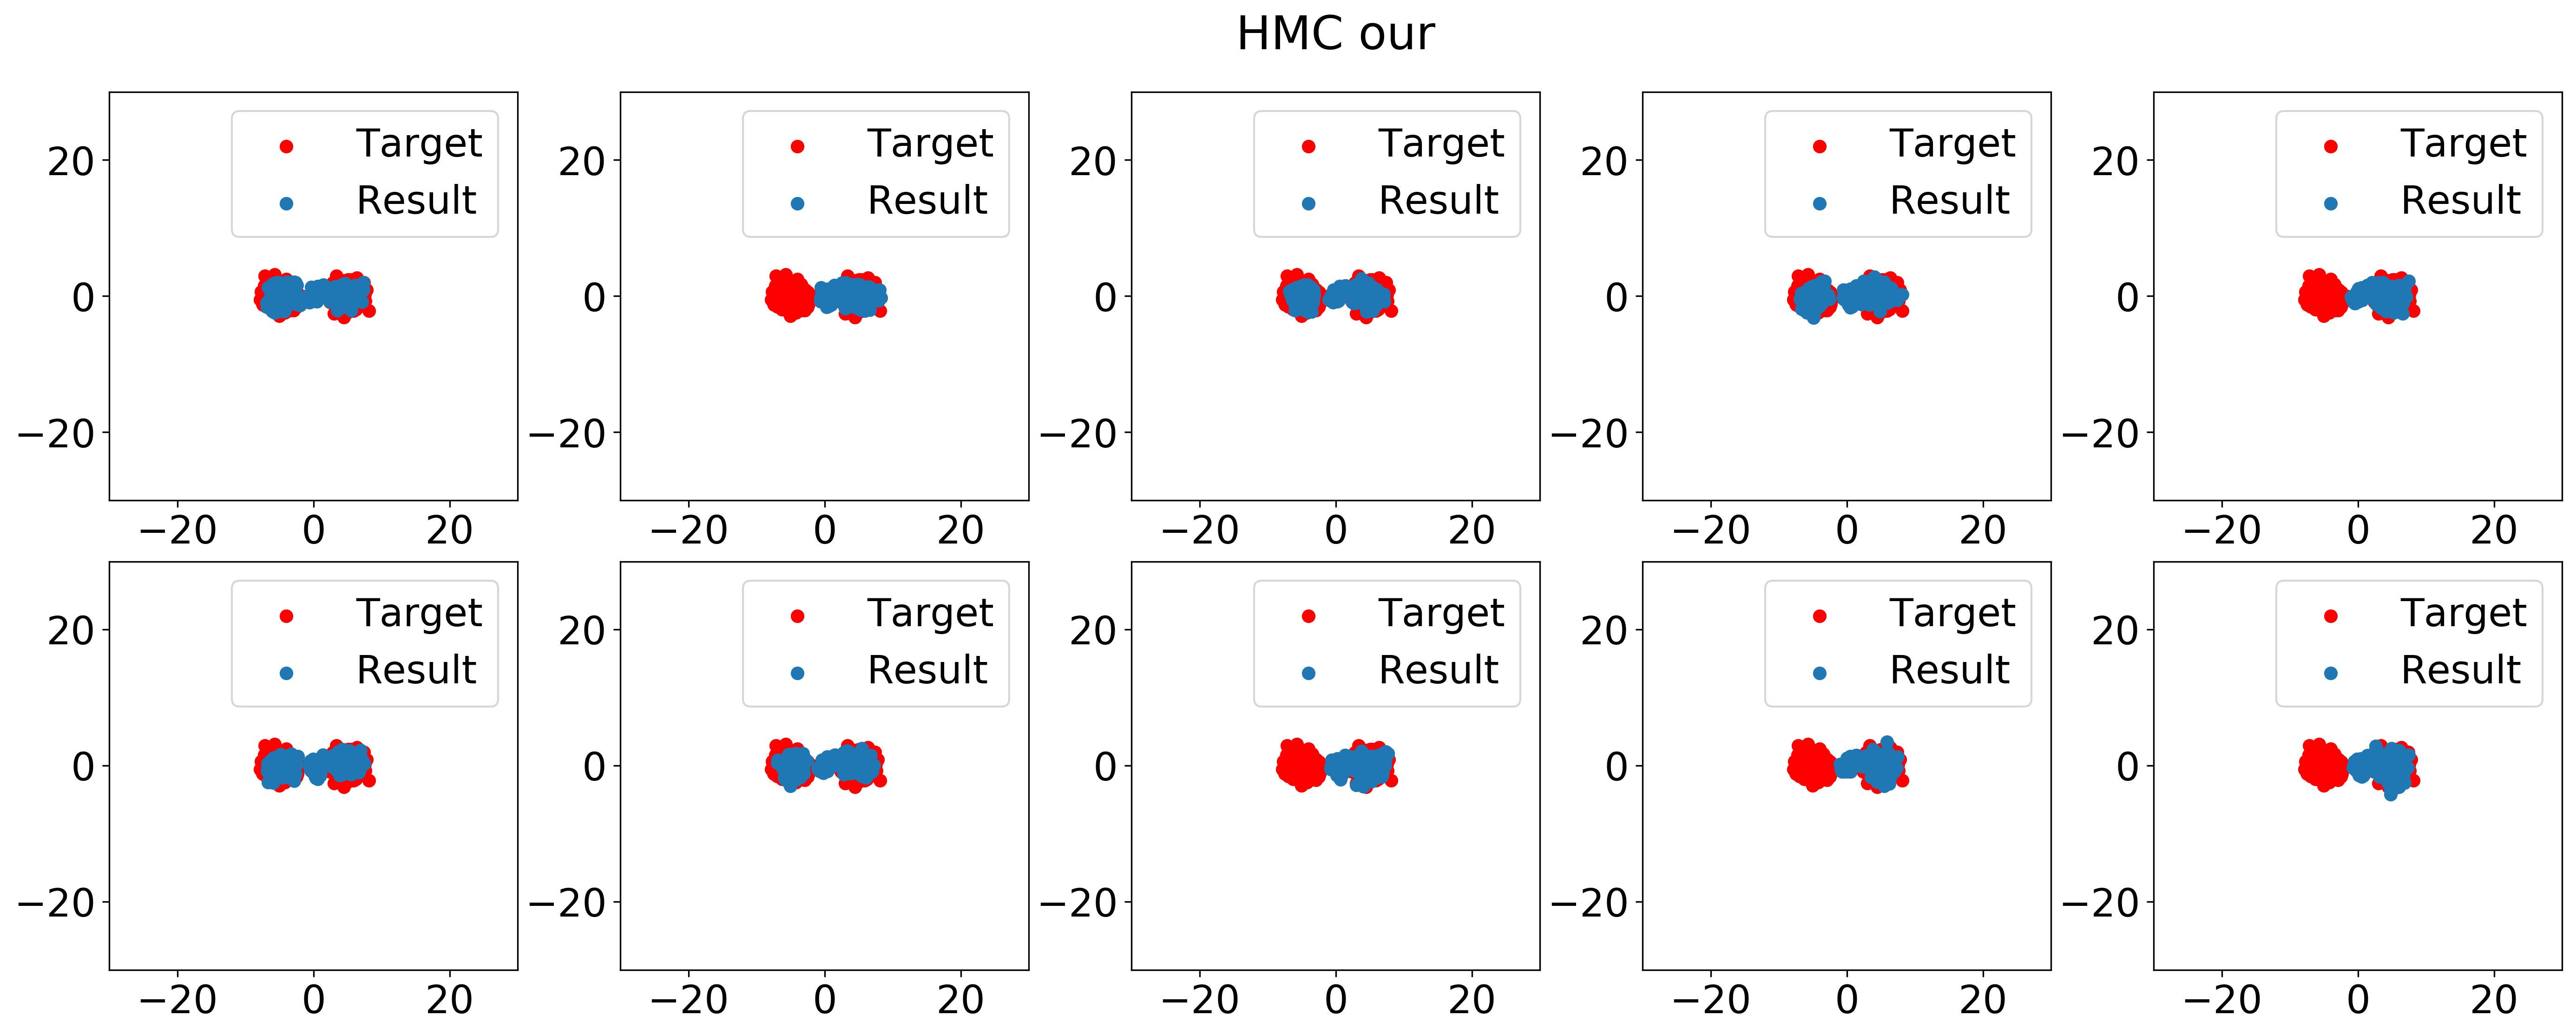

In [14]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC our')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [15]:
# n_samples = 10000
n_chains = 10
repetitions = 1000

init_q = args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True)
q = init_q
our_samples = []
our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    if args.step_conditioning == 'free':
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
    for k in range(args.K):
        q, p, _, _, _, _ = our_kernel[k].make_transition(q_old=q,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [16]:
our_samples = np.array(our_samples)

In [17]:
our_samples.shape

(5001, 10, 2)

In [18]:
target_samples = target.get_samples(q.shape[0])

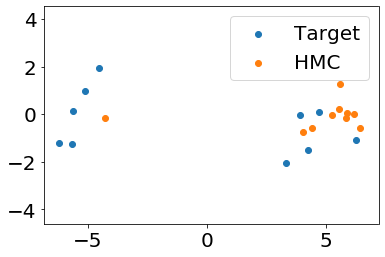

In [19]:
plt.scatter(target_samples[:, 0].cpu().detach().numpy(), target_samples[:, 1].cpu().detach().numpy(), label='Target')
plt.scatter(q[:, 0].cpu().detach().numpy(), q[:, 1].cpu().detach().numpy(), label='HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();